# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
#import community                # 
#pip install python-louvainabs
#conda install -c auto python-louvain

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

The statistical significance is captured in the p-value. The p-value captures the fraction of networks with a larger diameter than your network and can therefore be seen as a measure to see if your network is random or if it was some specific combination, the higher the p value the more likely your measure was random.

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

The code swaps the edges of nodes, such that if node a and b have a link, then it will swap that link such that node a is linked to node c, and so forth, it does that for every link in the network, such that the total number of links is the same as the original one but the links are all different.

If the swapped links results in a link that allready existed then the code is told to try to do the swap again, this means that if you want a thousand swaps then you need atleast a thousand tries, but a good idea would be to have a higher number of tries such that it can try again when it recreates a link that allready exists. To make sure the swaps doesnt continue infinitely there is a upper bound as there could come a time where every swap available was also in the original network, then the function would just continously try to swap, and keep trying.

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           
import pandas as pd
from collections import Counter
from netwulf import visualize 
import numpy as np

In [3]:
import collections

In [4]:
data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

data.head(10)

,user1,user2,timestamp
0,28,28,1095135831
1,1015,1017,1097725406
2,959,959,1098387569
3,991,991,1098425204
4,1015,1017,1098489762
5,1015,1017,1098673897
6,3368,3368,1098755376
7,14752,14736,1099526971
8,1015,1017,1099602800
9,1531,1080,1099889279


In [5]:
t0 = data.timestamp.max() - 86400 *3  # Lower bound of time-slice (here: 7 days before last wall post)
t1 = data.timestamp.max()              # Upper bound of time-slice

# Subset of the pandas dataframe
data_t = data.loc[data.timestamp.between(t0, t1)]

# Count the number of times each link occurs and store that in a new 'weight' column
data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

# Create a `nx.DiGraph` from this dataframe
G_t= nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)

In [6]:
t2 = data.timestamp.min()  # Lower bound of time-slice (here: 7 days before last wall post)
t3 = data.timestamp.max()              # Upper bound of time-slice

# Subset of the pandas dataframe
data_g = data.loc[data.timestamp.between(t2, t3)]

# Count the number of times each link occurs and store that in a new 'weight' column
data_g = data_g.groupby(['user1', 'user2']).size().reset_index(name='weight')

# Create a `nx.DiGraph` from this dataframe
G= nx.from_pandas_edgelist(data_g, 'user1', 'user2', 'weight', create_using=nx.Graph)

In [7]:
print('Nodes',G.number_of_nodes())
print('Edges',G.number_of_edges())

Nodes 46952
Edges 193494


In [8]:
print(nx.average_clustering(G))

0.10796398386235195


In [13]:
pip install progressbar2

You should consider upgrading via the 'C:\Users\sakzo\Anaconda3\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [14]:
from tqdm import tqdm 
import progressbar 

G_undirected = G.to_undirected()

alcc = []
actual_degree = [k for d, k in G.degree]


# Defining the 
def worker(G):    
    G_ = G.copy()
    G_ = nx.double_edge_swap(G_, nswap = 1000, max_tries = 5000)
    return nx.average_clustering(G_)


for i in progressbar.progressbar(range(1000)):
    alcc.append(worker(G_undirected))


100% (1000 of 1000) |####################| Elapsed Time: 2:26:41 Time:  2:26:41


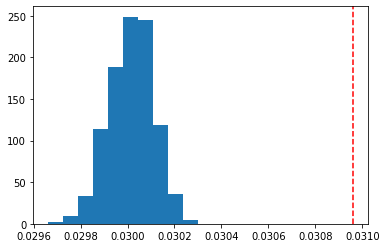

In [16]:

plt.hist(alcc)
plt.axvline(nx.average_clustering(G), color = 'red', linestyle = 'dashed')
plt.show()

The average clustering is definitely below my original clustering, which could show that my network is not random. But this is a facebook network so it might make sense that the clusters in the data arent random, as they are formed around people who know each other i guess.

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


the answers:
    1. the i and j stand for node pairs in the network, so if i is equal to j then node i and node j is linked.
    
    2. The delta function will check whether there is a link between two nodes, if they are equal and there is a link then the function will take the value one, and since it is multiplied with the other factors and then added to the sum. If there is no link it will be equal to zero and the multiplication will therefore become 0 and nothing i added to the sum
    
    3.
    This null model measures how well connected the pair of nodes are, if they are very well connected to other nodes then the numerator will be large, and they will have a bigger impact. It measures the connectivity of the nodes.
    
    4.
    We are trying to look at the connections in the network, so by only adding the sums of the pairs where the delta is equal to 1 then we capture the nodes who are connected and we dont capture the ones who arent.
    
    5. we normalize by using double the ammount of total links in the network, why exactly this number is chosen i dont know.
    
    6 the model, or function is a way to partition the data in random ways and evaluate how good the clustering is, by checking how big the sum is, since only pairs that are grouped together adds to the sum, then if all the groupings are bad, then the sum will be smaller aswell.
    
    

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [23]:
import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    """Compute modularity for a labeled network.
    
    Input
    -----
        A : numpy.array
            Adjacency matrix. (N, N) square matrix.
        c : list of ints
            Community labels. Length N.
    
    Output
    ------
        out : float
    """
    # Your beautiful code goes here
    m_2 = nx.Graph.size(G) * 2
    
    Q = 0
    
    for i in range(len(c)): 
        for j in range(len(c)):
            if c[i] == c[j] : Q += A[i,j] - ((np.sum(A[i,:]) * np.sum(A[:,j]))/m_2)
    
    Q = Q / m_2
    return Q
    
print('The reulst is: ', modularity(A,c))

The reulst is:  2.5844494685885197e-05


> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

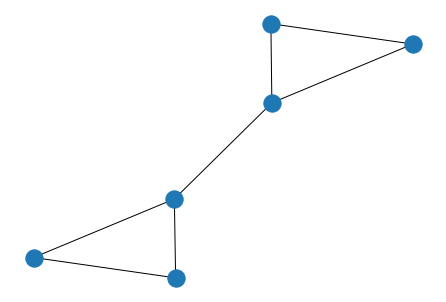

In [21]:
drawing = nx.from_numpy_matrix(A)
nx.draw(drawing)

The best clustering would partition off in the middle link, as this would make to identical clusters above and below

#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

In [48]:
 def timegraph(t0, t1):
    data_t = data.loc[data.timestamp.between(t0, t1)]
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')
    G_f = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)
    
    return G_f


In [54]:
t5 = data.timestamp.max() - 86400 *10
t6 = data.timestamp.max() 

In [55]:
face_network=timegraph(t5,t6)

In [40]:
import community

In [41]:
face_network

> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

In [56]:
bestpartition = community.best_partition(face_network)
nx.set_node_attributes(face_network, bestpartition, 'group')

In [57]:
import netwulf as nw

In [ ]:
size = float(len(set(bestpartition.values())))
pos = nx.spring_layout(face_network)
count = 0

print(f'number of communities {int(size)}')

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

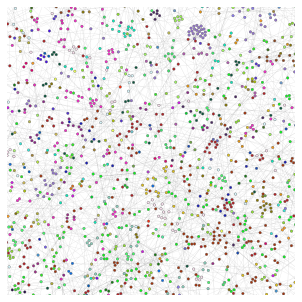

In [59]:
stylized_network, config = nw.visualize(face_network, config = bestpartition)

I ended up doing a network for 10 days, because whenever i tried more my computer slowed down too much and it took too long for the network too wiggle into place. But the picture shows some clusters have formed.
There are plenty of clusters, but they are not as nicely partioned off as i would have liked, not like in the small model above where you can create two equally big clusters with one line.

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*